## Molecular dynamic simulation of a mini-crystal
### David Omanovic
This computational project will explore the statistical mechanics of a mini-crystal in two
dimensions. The particles in the crystal have kinetic energy and are held together by potential
energy (interactions). The motion of the particles is found by direct numerical integration of
Newton’s equations.

We shall consider N particles with two dimensional positions in a plane given by the vectors $\vec{r_i} = (x_i, y_i)$. The
interaction energy between any two particles i and j is given by the Lennard-Jones potential:

\begin{equation}
V(r_{ij}) = 4 \epsilon \left[ \left( \frac{a}{r_{ij}} \right)^{12}- \left( \frac{a}{r_{ij}} \right)^{6}\right]
\end{equation}

where $r_{ij} = |r_i−r_j|$ is the distance between particle $i$ and $j$, and the strength of the interaction is determined by the parameter $\epsilon > 0$.

The potential energy between two particles is at a minimum at the distance $r_0 ≈ 1.12a$,
and the minimum energy is $−\epsilon$.
The force is repulsive when $r_{ij} < r_0$, and attractive when $r_{ij} > r_0$. The potential energy
increases fast when $r_{ij} < r_0$, and the length $r_0$ therefore roughly defines the size (diameter)
of particles. Newton’s equations of motion (Newton's second Law of motion) is then:

\begin{equation}
m\frac{d^2 \vec{r_i}}{dt^2} = \vec{f_i} = - \sum_{j \neq i} \frac{\partial V(r_{ij})}{\partial \vec{r_i}} = \sum_{j \neq i} 4 \epsilon \left( \frac{12a^{12}}{r_{ij}^{13}} - \frac{6a^{6}}{r_{ij}^{7}} \right)
\end{equation}

### 0. Dimensionless equations
When doing numerical simulations it is convenient to rescale Newton equations so they
become dimensionless, i.e. we measure distance and time not in meters and seconds, but in
some characteristic length and timescale. Show that the equations becomes dimensionless if
we express positions in units of a and time in units $\tau  = \sqrt{\frac{ma^2}{\epsilon}}$, i.e the position is given by $x_i = \tilde{x_i}a$ and $y_i = \tilde{y_i}a$ and time is $t = \tilde{t}\tau$, where the dimensionless numbers are: $\tilde{x_i}, \tilde{y_i}, \tilde t$.


Doing some quick dimension analysis, we expect $\tau$ to have dimensions of $[s]$ so that it can make a reduced unit of time, namely $\tilde{t} = t \cdot \tau^{-1}$. Taking into account that mass has units of $kg$, distance $a$ has units of $m$ and the dispersion energy $\epsilon$ has units of $J$, we get
\begin{equation}
[\tau] = \sqrt{ma^2/\epsilon} = \sqrt{\frac{kg \cdot m^2}{J}} =\\
\sqrt{\frac{kg \cdot m^2}{kg \cdot m^2/s^2}} = [s]
\end{equation}
The length $a$ has units of $[m]$ such that the reduced positions are $\tilde r = \frac ra$

### Two particles (N = 2)

1a) Write a program to simulate two particles (using the dimensionless form of the equations).
As initial conditions you may let the distance between particles be r = 1.1a, and velocities
can be zero. The timestep can be ∆t = 0.01τ.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#dimensionless init conds
r0 = 1.12 # initial reduced distance between particle 1 and 2
v0 = 0 # initial velocity
T = 5 #period

def Verlet(r0, v0, dt, N):
    """
    Verlet Algorithm for solving Newtonian systems of 2 particles.
    """ 
    m = 1 # Mass (dimensionless)
    r = np.zeros(N) # position
    v = np.zeros(N) # velocity
    f = np.zeros(N) # Force
    K = np.zeros(N) # Kinetic energy
    V = np.zeros(N) # Potential energy

    r[0] = r0; v[0] = v0; f[0] = 4 * (12/(r0**13)-6/(r0**7)) # setting initial conditions
    K[0] = 0; V[0] =  4 * (r0**(-12) - r0**(-6))

    for i in range(N-1):
        r[i+1] = r[i] + v[i]*dt + 1/2 * f[i]/m * dt**2 # Update particle position according to Newton
        f[i+1] = 4 * (12 * r[i]**(-13) - 6 * r[i]**(-7)) # Lennard Jones potenial
        v[i+1] = v[i] + (f[i] + f[i+1])/(2*m) * dt # Update particle velocity according to Newton
        K[i+1] = 1/2 * v[i]**2  # Update kinetic energy
        V[i+1] = 4 * (r[i]**(-12) - r[i]**(-6)) # Update potential energy

    return r, v, f, K, V
    

In [3]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 7), dpi=800)

# List of time step values
time_steps = [0.1, 0.01, 0.001]

for i, step in enumerate(time_steps):
    N_step = int(T / step)
    t = np.linspace(0, T, N_step)
    r, v, f, K, V = Verlet(r0, v0, step, N_step)
    
    axs[0][i].plot(t, r)
    axs[0][i].set_xlabel(r"$\tilde{t}$", size=12)
    axs[0][i].set_ylabel(r"$\tilde{r_{ij}}$", size=12)
    axs[0][i].set_title(rf"$\Delta t$ : {step}$\tau$")
    
    axs[1][i].set_title("Total Mechanical Energy")
    axs[1][i].plot(t, K, t, V+1, t, (V+1)+K)
    axs[1][i].set_xlabel(r"$\tilde{t}$", size=12)
    axs[1][i].set_ylabel(r"$\tilde{\epsilon}$", size=12)

plt.tight_layout()
plt.show()

With appropriate time steps we see approximately conserved mechanical energy. Quite horrific simulations with a big timestep
0.1 $\tau$. The solution diverges over time, because the total mechanical energy should be conserved, i.e. the green curve should stay constant.

### 2. Mini-crystal

With the current framework we have, we can simulate a mini-crystal. A way to do this is to arrange a hexagonal crystal lattice. Why would we use hexagonal crystal packing? Well that is because it has the highest packing fraction, and we can fit the most atoms in the grid. This would correspond to an approximate solid, like an ice cube.

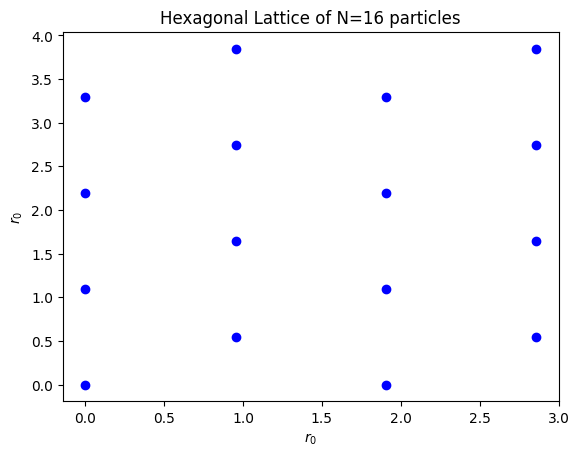

In [4]:
def hexagon(N, r):
    k = int(np.sqrt(N))
    vertex = np.array([[np.zeros(k)], [np.arange(0, k + (0.2*k/2), r)]]).reshape(2, k).T
    R = vertex
    z = int(np.sqrt(N))
    for i in range(1, z):
        vec = np.array([[np.ones(z)*r*np.sin(np.pi/3)], [np.ones(z)*np.cos(np.pi/3)*r*(-1)**(i+1)]]).reshape(2, z).T
        R = np.concatenate((R, vertex+vec), axis=0)
        vertex += vec
    return R

N = 16 # Number of particles
r0 = 1.1 # Size of particle

df = hexagon(int(N), r0) # Initalize hexagonal position array

# Initialize particle positions and velocities
plt.title(f"Hexagonal Lattice of N={N} particles")
plt.scatter(df[:,0], df[:,1], c="blue", marker='o')
plt.xlabel(r"$r_0$")
plt.ylabel(r"$r_0$")
plt.show()

Next we want to generate values for the distance between the particles in the grid, the Lennard-Jones potential and then plug and chug this into the Verlet algorithm, so that we can integrate Newton's equations for all the particles above in the grid.

In [5]:
def r_ij(r, i, j, t):
    "Find the distance of some particle i and j with their r-vector at some time point t"
    r_ij = np.linalg.norm((r[i, :, t] - r[j, :, t]))  # length of some r_ij vector at some time
    r_hat = np.array((r[i, :, t] - r[j, :, t]) / r_ij)  # unit r_ij vector
    return r_ij, r_hat

def V_LJ(rij, epsilon=1.0):
    "Calculate the lennard jones potenital"

    r6 = (rij ** 6)
    r12 = r6 * r6
    return 4 * epsilon * (1/r12 - 1/r6)

def dV(rij):
    "Calculate the force of the Lennard Jones potential V_LJ"

    return -48 * ((rij ** -13) - 0.5 * (rij ** -7))

def GeneralizedVerlet(r0, v0, dt, N, T, r_s=1.1):
    """
    Simulate Molecular Dynamics with the Velocity Verlet algorithm
    r0: initial positions
    v0: initial velocities
    dt: step length
    N: number of particles
    T: number of time steps
    r_s: molecule size
    """
    
    # Initialize arrays for positions, velocities, forces, and energies for all particles
    r = np.zeros((N, 2, T))  # Position
    v = np.zeros((N, 2, T))  # Velocity
    f = np.zeros((N, 2, T))  # Force
    K = np.zeros((N, T))  # Kinetic Energy
    V = np.zeros((N, T))  # Potential Energy

    # Initial conditions: positions, velocities, forces, kinetic and potential energy.
    r[:, :, 0] = r0
    v[:, :, 0] = v0
    K[:, 0] = 0.5 * np.sum(v0**2, axis=1)

    for t in range(T - 1):
        r_t = r[:, :, t]
        f[:, :, t] = 0  # Reset forces for this time step
        V_t = np.zeros(N)

        for i in range(N):
            r_i = r_t[i]
            r_diff = r_t - r_i
            rij = np.linalg.norm(r_diff, axis=1)
            rij[i] = np.inf  # Exclude the particle itself
            r_hat = r_diff / rij[:, np.newaxis]

            within_cutoff = rij < 3 * r_s
            V_t += np.sum(V_LJ(rij[within_cutoff], 1))

            f_i = np.sum(dV(rij[within_cutoff])[:, np.newaxis] * r_hat[within_cutoff], axis=0)
            f[i, :, t] = f_i

        V[:, t] = V_t

        v[:, :, t + 1] = v[:, :, t] + 0.5 * (f[:, :, t] + f[:, :, t + 1]) * dt
        r[:, :, t + 1] = r[:, :, t] + v[:, :, t + 1] * dt

        K[:, t + 1] = 0.5 * np.sum(v[:, :, t + 1]**2, axis=1)

    return r, v, K, V

In [6]:
def plotter(r, i, j, t):
    # Particle Indices
    p1 = i; p2 = j
    dist = np.zeros(len(t))
    for k in range(len(t)):
        dist[k] = np.linalg.norm(r[p1, :, k] - r[p2, :, k])

    # Now you can plot the distances as a function of time
    plt.plot(t, dist)
    plt.xlabel(r"$\tilde{t}$", size=12)
    plt.ylabel(r"$\tilde{r_ij}$", size=12)
    plt.title(f"Distance between Particle {p1+1} and Particle {p2+1} over Time")
    plt.show()

If we now just set some specific numerical values, like 16 particles, with atomic radiuses of $1.1 Å$, and an initial velocity of $0.01 m/s$ for instance, we can expect small oscillations in the positions of the particles in the hexagon grid sort of like an ice cube melting by heating it up. The oscillations should be of the order of our time step $dt = 10^{-3}$.

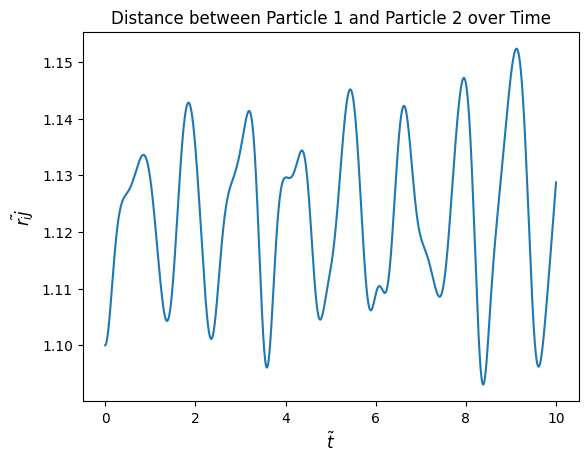

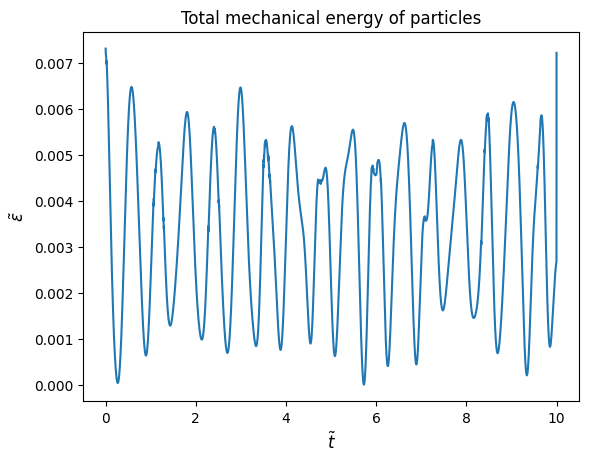

In [7]:
N = 16 # Particles
r0 = 1.1 # Distances
V0 = 0.01  # Initial velocity magnitude (aτ)
T = 10 # Total simulation time
dt = 0.001  # Time step (aτ)
t = np.arange(0, T, dt)
positions = hexagon(int(N), r0) # Initalize hexagonal position array
vel0 = np.random.choice([-V0, V0], (N, 2))  # Random set of velocities

# Extract position, velocity, kinetic and potential energy vectors
r, v, K, V= GeneralizedVerlet(positions, vel0, dt, N, len(t))

# Particle Indices
plotter(r, 0, 1, t)

E = np.sum(V+K, axis=0)
s = np.abs(np.min(E)) #scaling factor
E[-1] = E[1]
plt.plot(t, 1+E/s)
plt.xlabel(r"$\tilde{t}$", size=12)
plt.ylabel(r"$\tilde{\epsilon}$", size=12)
plt.title("Total mechanical energy of particles")
plt.show()


There are slight oscillations, but on the order of $10^{-3}$, which is the timestep. This is a good sign, and indicates that our algorithm is converging.

We will now try the same with 49 particles. What do you expect the differences to be? Should the oscillations increase since there are more particles, accounting for more interactions? Let us see.

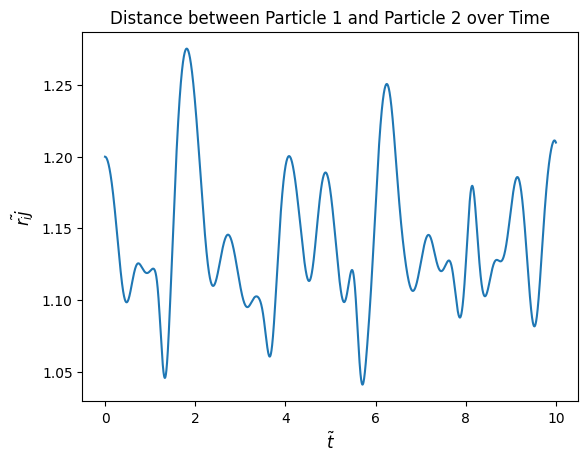

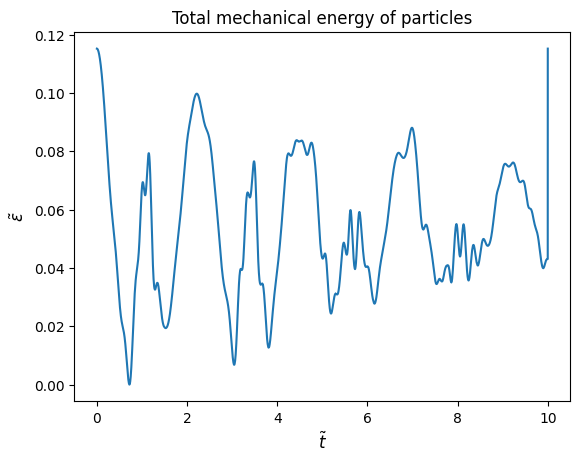

In [8]:
N = 49 # Particles
r0 = 1.2 # Distances
V0 = 0.01  # Initial velocity magnitude (aτ)
T = 10 # Total simulation time
dt = 0.001  # Time step (aτ)
t = np.arange(0, T, dt)
positions2 = hexagon(int(N), r0) # Initalize hexagonal position array
vel02 = np.random.choice([-V0, V0], (N, 2))  # Random set of velocities

# Extract position, velocity, kinetic and potential energy vectors
r2, v2, K2, V2 = GeneralizedVerlet(positions2, vel02, dt, N, len(t))

# Particle Indices
p1 = 0; p2 = 1
dist = np.zeros(len(t))
for i in range(len(t)):
    dist[i] = np.linalg.norm(r2[p1, :, i] - r2[p2, :, i])

# Now you can plot the distances as a function of time
plt.plot(t, dist)
plt.xlabel(r"$\tilde{t}$", size=12)
plt.ylabel(r"$\tilde{r_ij}$", size=12)
plt.title(f"Distance between Particle {p1+1} and Particle {p2+1} over Time")
plt.show()

E = np.sum(V2+K2, axis=0)
s = np.abs(np.min(E)) #scaling factor
E[-1] = E[1]
plt.plot(t, 1+E/s)
plt.xlabel(r"$\tilde{t}$", size=12)
plt.ylabel(r"$\tilde{\epsilon}$", size=12)
plt.title("Total mechanical energy of particles")
plt.show()

It is apparent that more particles have caused more chaotic behavior. The oscillations are getting more aperiodic. This corresponds exactly to what the Lennard Jones potential is telling us. The repulsion and attraction between particles is more apparent when we have more particles in our system. 

If the system is ergodic we expect that the fluctuations in particle velocities should
follow the Maxwell statistical distribution. Let us plot our velocities and compare it to actual Maxwell-Boltzmann distribution.

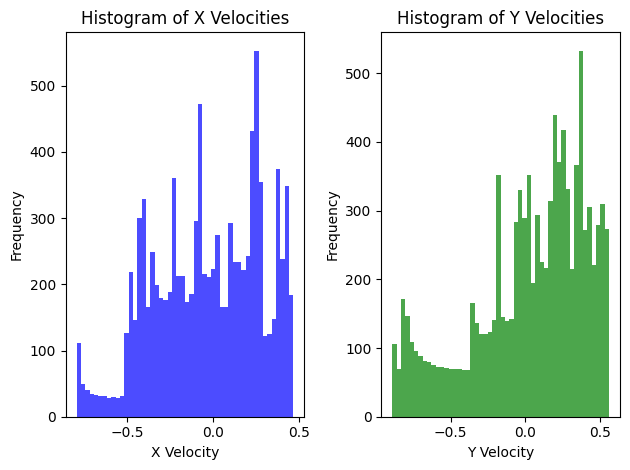

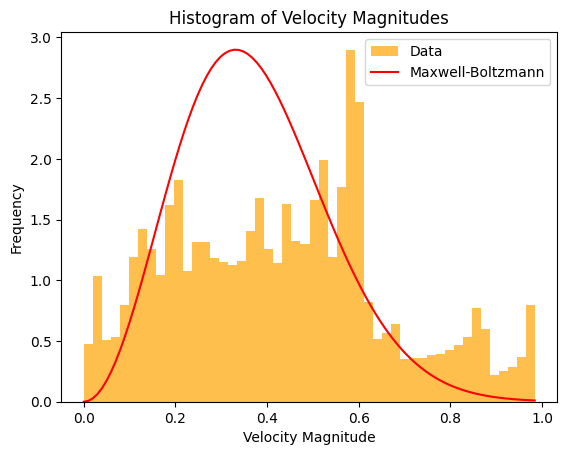

In [9]:
from scipy.stats import maxwell
# Choose a particle
particle = 0

# Extract the x and y velocities for the selected particle
vx = v2[particle, 0, :]
vy = v2[particle, 1, :]

# Create histograms for x and y velocities
plt.subplot(1, 2, 1)
plt.hist(vx, bins=50, color='blue', alpha=0.7)
plt.xlabel('X Velocity')
plt.ylabel('Frequency')
plt.title('Histogram of X Velocities')

plt.subplot(1, 2, 2)
plt.hist(vy, bins=50, color='green', alpha=0.7)
plt.xlabel('Y Velocity')
plt.ylabel('Frequency')
plt.title('Histogram of Y Velocities')
plt.tight_layout()
plt.show()

v_abs = np.sqrt(vx**2+vy**2)
hist_v, bins_v, _ = plt.hist(np.abs(v_abs), bins=50, density=True, color='orange', alpha=0.7, label='Data')
plt.xlabel('Velocity Magnitude')
plt.ylabel('Frequency')
plt.title('Histogram of Velocity Magnitudes')
# Overlay the Maxwell-Boltzmann distribution on the velocity magnitude histogram
v_range = np.linspace(0, np.max(np.abs(v_abs)), 100)
maxwell_v = maxwell.pdf(v_range, scale=np.std(np.abs(v_abs)))
scaling_factor_v = np.max(hist_v) / np.max(maxwell_v)
plt.plot(v_range, maxwell_v * scaling_factor_v, 'r-', label='Maxwell-Boltzmann')
plt.legend()
plt.show()

We observe some resemblance of the Maxwell-Boltzmann PDF, although not perfect. This is because we are far away from the thermodynamic limit of $N \to \infty$. Let's try calculating the total average kinetic energy and potential energy over time for different velocities.

When the kinetic energy is close to zero, the potential energy is at its minimum value. This is expected because particles at very low kinetic energies tend to be in a stable, low-energy configuration.
As the kinetic energy increases, the potential energy also increases. This relationship is often observed in systems where kinetic and potential energy are related, they are competing constantly.
The initial part of the plot may exhibit a linear dependence between potential and kinetic energy, indicating a simple relationship between the two. This linear behavior can be seen at lower kinetic energies.
At higher kinetic energies, the relationship may become more complex as the particles interact with each other in a more dynamic and energetic manner. The potential energy may no longer have a simple linear relationship with kinetic energy.




If the initial velocities are increased to larger values there should be noticeably higher
fluctuations (oscillations in distance between particles). The crystal will evaporate when it stops oscillating and the distances increase drastically. We can animate it as well!

(-10.0, 10.0)

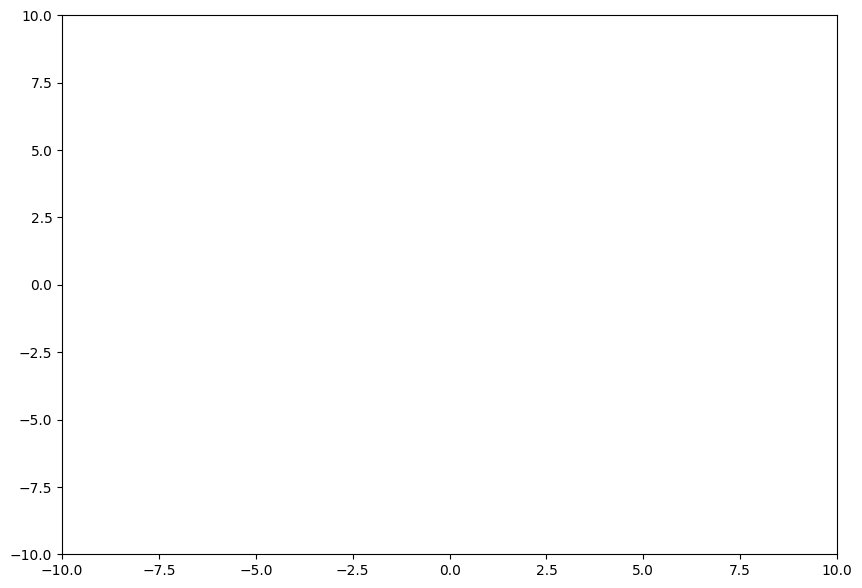

In [19]:
#Simple animation
k = 30
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

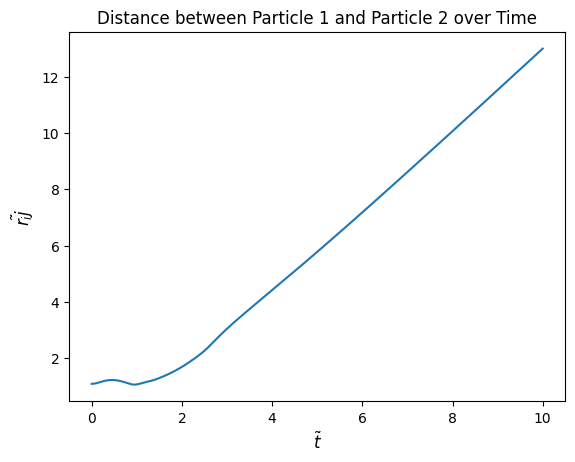

In [22]:
N = 49 # Particles
r0 = 1.1 # Distances
V0 = 2  # Initial velocity magnitude (aτ)
T = 10 # Total simulation time
dt = 0.001  # Time step (aτ)
t = np.arange(0, T, dt)
positions = hexagon(int(N), r0) # Initalize hexagonal position array
vel0 = np.random.choice([-V0, V0], (N, 2))  # Random set of velocities

# Extract position, velocity, kinetic and potential energy vectors
r, v, K, V= GeneralizedVerlet(positions, vel0, dt, N, len(t))

plotter(r, 0, 1, t)

scat = ax.scatter(r[:,0,:] , r[:,1,:])
def animate(i):
    scat.set_offsets(np.c_[r[:, 0, i*10] , r[:, 1, i*10]])
anim = FuncAnimation(fig, animate, interval = 10, frames=int(len(t)/T), repeat=True)

HTML(anim.to_html5_video())

With velocity being $V_0 = 2$, we experience a sort of gas like behaviour from the particles in a crystal. This is because the particles now have enough kinetic energy to escape the potenital and roam freely in some arbitrary volume. We observe also by the graph that if the initial velocities are increased to larger values there should be noticeably higher fluctuations (oscillations in distance between particles). For a large enough velocity, the distance just increases with time, meaning that the particles have escaped the hexagonal lattice. 

Testing out the simulation with different $V_0$ can also indicate when the system is in a liquid state, by seeing if it doesn't escape the lattice structure but rather oscillates around some equlibirium, but of larger scale than earlier. Some reasonable guess with $V_0=0.6$, we can observe some liquid-like behaviour where the particles are moving around in space, but are keeping their structure with the hexagonal lattice. We can see it clearly in the animation, but it is also visible in the distance graph because it always return to $r_0 = 1.1$ in its fluctuations.

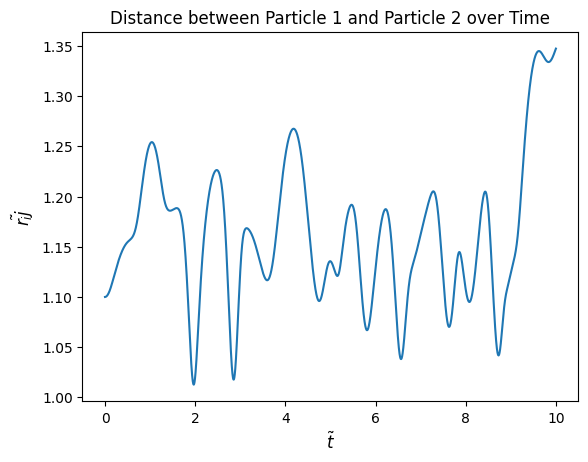

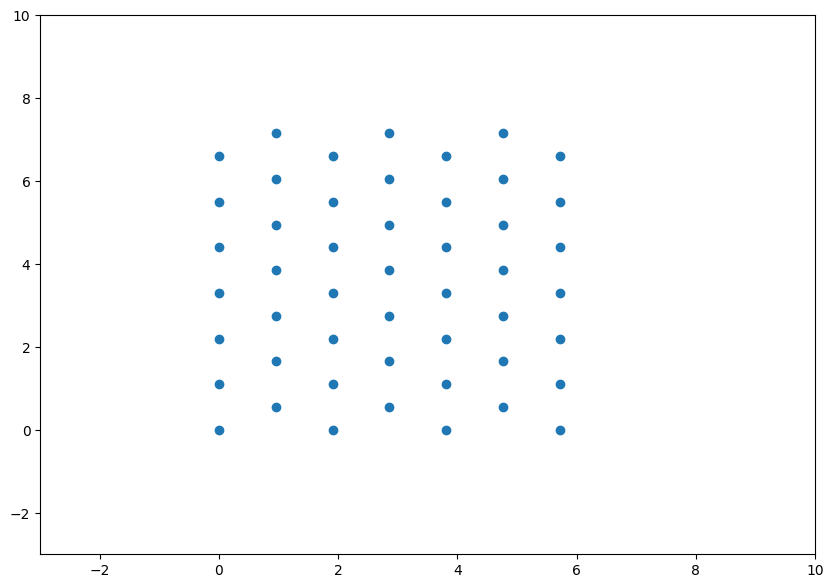

In [12]:
N = 49 # Particles
r0 = 1.1 # Distances
V0 = 0.6  # Initial velocity magnitude (aτ)
T = 10 # Total simulation time
dt = 0.001  # Time step (aτ)
t = np.arange(0, T, dt)
positions = hexagon(int(N), r0) # Initalize hexagonal position array
vel0 = np.random.choice([-V0, V0], (N, 2))  # Random set of velocities

# Extract position, velocity, kinetic and potential energy vectors
r, v, K, V= GeneralizedVerlet(positions, vel0, dt, N, len(t))

plotter(r, 0, 1, t)


scat = ax.scatter(r[:,0,:] , r[:,1,:])

def animate(i):
    scat.set_offsets(np.c_[r[:, 0, i*10] , r[:, 1, i*10]])

anim = FuncAnimation(fig, animate, interval = 10, frames=int(len(t)/T), repeat = True)

HTML(anim.to_html5_video())

One last step is to try and simulate the oscillations of more particles. In a glass of water, we have $N\approx 4\times 10^{23}$ atoms of water. So in our powerful algorithm, we can animate a fraction of that $(0.00000000000000000000001 \%)$ in approximately two minutes. For that reason, we call for more optimized methods. The Verlet algorithm is great for its simplicity and stability, but we will have to explore more efficient methods for our force calculations.

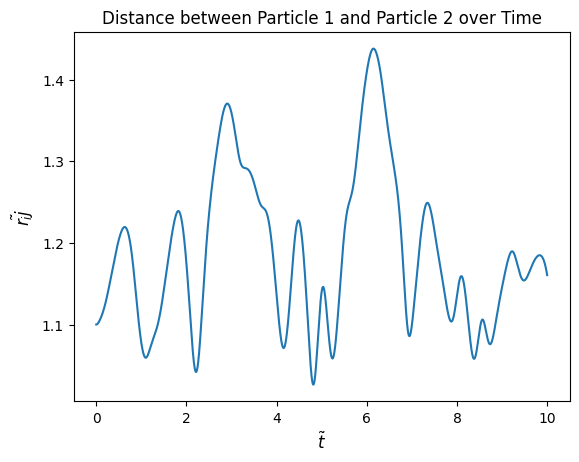

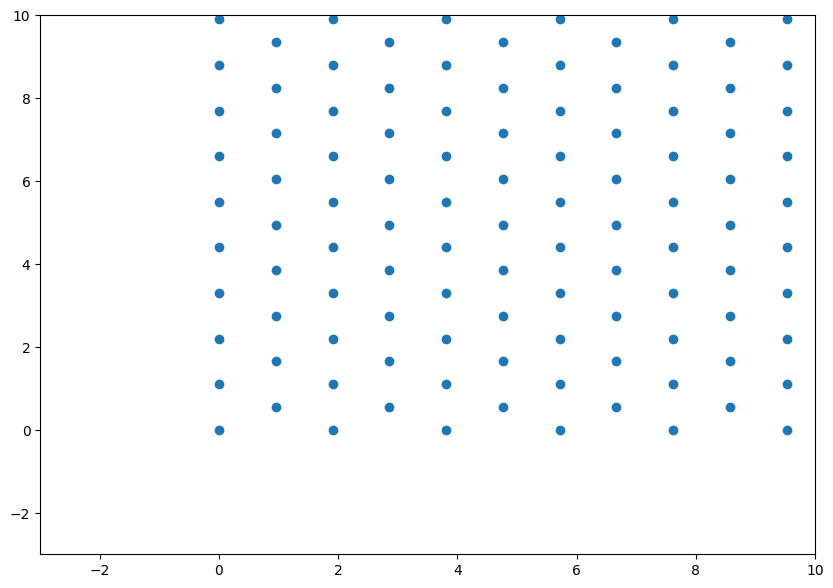

In [16]:
N = 196 # Particles
r0 = 1.1 # Distances
V0 = 0.6  # Initial velocity magnitude (aτ)
T = 10 # Total simulation time
dt = 0.001  # Time step (aτ)
t = np.arange(0, T, dt)
positions = hexagon(int(N), r0) # Initalize hexagonal position array
vel0 = np.random.choice([-V0, V0], (N, 2))  # Random set of velocities

# Extract position, velocity, kinetic and potential energy vectors
r, v, K, V= GeneralizedVerlet(positions, vel0, dt, N, len(t))
scat = ax.scatter(r[:,0,:] , r[:,1,:])

HTML(anim.to_html5_video())